In [1]:
import tensorflow as tf
import numpy as np
import os
from skimage import io, transform, measure
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib import image
plt.rcParams['figure.figsize'] = [12,8]

In [2]:
train_inputs = os.listdir('cancer_data/inputs/train')
test_inputs = os.listdir('cancer_data/inputs/test')
# trd, trl, tstd, tstl = [], [], [], []
test_neg_inds = np.random.randint(0, 100, 10)
test_pos_inds = np.random.randint(100, 175, 10)
test_inds = np.append(test_neg_inds, test_pos_inds)
train_neg_inds = np.random.randint(0, 671, 50)
train_pos_inds = np.random.randint(671, 1342, 50)
train_inds = np.append(train_neg_inds, train_pos_inds)
# consider using random.sample to pick random subset
"""for i in train_inds:
    trd.append(transform.resize(io.imread('cancer_data/inputs/train/' + train_inputs[i]), (512,512,3), mode='constant'))
    trl.append(transform.resize(io.imread('cancer_data/outputs/train/' + train_inputs[i]), (512,512,3), 
                                order=0, mode='constant')[:,:,1])
for j in test_inds:
    tstd.append(transform.resize(io.imread('cancer_data/inputs/test/' + test_inputs[j]), (512,512,3), mode='constant'))
    tstl.append(transform.resize(io.imread('cancer_data/outputs/test/' + test_inputs[j]), (512,512,3), 
                                 order=0, mode='constant')[:,:,1])"""
print(test_inds)

[ 95   7  87  75  42   0   5  20  59  68 167 127 109 112 151 110 138 148
 111 166]


In [3]:
def conv(x, filter_size=3, stride=1, num_filters=64, is_output=False, name="conv"):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Convolve x with W by calling the tf.nn.conv2d function
      Add the bias
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    ''' 
    shape = x.get_shape().as_list()
    with tf.name_scope(name) as scope:
        W = tf.get_variable("W_{}".format(name), [filter_size, filter_size, shape[-1], num_filters], 
                             dtype = tf.float32, initializer = tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("b_{}".format(name), [num_filters], dtype = tf.float32, 
                            initializer = tf.contrib.layers.variance_scaling_initializer())
        C = tf.nn.conv2d(x, W, [1, stride, stride, 1], padding="SAME")
        C1 = tf.nn.bias_add(C, b)
        if not is_output:
            h = tf.nn.relu(C1)
            return h
    return C1

## No Regularization

In [4]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [1,512,512,3])
y_hat = tf.placeholder(tf.float32, [1,512,512,1])
y_true = tf.placeholder(tf.float32, [1,512,512,1])

# h = conv(x, name="h", num_filters=64)
h0 = conv(x, name="h0", num_filters=32)
h1 = conv(h0, name="h1", num_filters=16)
h2 = conv(h1, name='h2', is_output=True, num_filters=1)
print h2.get_shape().as_list()

with tf.name_scope("loss_function") as scope:
    cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(h2, (1,512*512)), 
                                                                          labels=tf.reshape(y_true, (1,512*512))))

# accuracy = number of correct pixels (each pixel is probability of cancer)
with tf.name_scope("accuracy") as scope:
    y_hat = tf.cast(h2>.5, tf.float32)
    correct_prediction = tf.equal(y_true, y_hat)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

[1, 512, 512, 1]


100 TRAIN ACC: 0.989315509796	 TEST ACC: 0.885489654541	 LOSS: 1.82102164461
----------------------------------------------------------------------------------------------------
200 TRAIN ACC: 0.994283437729	 TEST ACC: 0.885489654541	 LOSS: 1.42557183668
----------------------------------------------------------------------------------------------------
300 TRAIN ACC: 0.996178269386	 TEST ACC: 0.885489654541	 LOSS: 1.55488046168
----------------------------------------------------------------------------------------------------
400 TRAIN ACC: 0.996178269386	 TEST ACC: 0.885489654541	 LOSS: 1.14352026005
----------------------------------------------------------------------------------------------------
500 TRAIN ACC: 0.993391275406	 TEST ACC: 0.885489654541	 LOSS: 1.14560831634
----------------------------------------------------------------------------------------------------
600 TRAIN ACC: 0.995058774948	 TEST ACC: 0.885489654541	 LOSS: 1.22623828989
---------------------------------

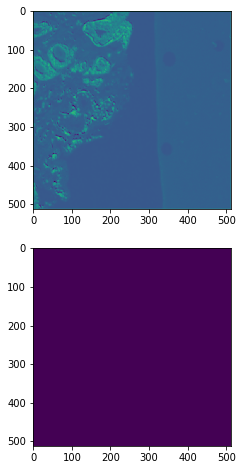

In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

train_writer = tf.summary.FileWriter("./tf_logs", sess.graph)

accuracies, losses, train_acc = [], [], []
epochs = 1000
for i in xrange(epochs):
    ind1 = np.random.randint(len(train_inds))
    img = transform.resize(io.imread('cancer_data/inputs/train/' + train_inputs[ind1]), (512,512,3), 
                           mode='constant').reshape((1,512,512,3))
    lbl = transform.resize(io.imread('cancer_data/outputs/train/' + train_inputs[ind1]), (512,512,3), 
                           order=0, mode='constant')[:,:,1].reshape((1,512,512,1))
    _, _, acc = sess.run([train_step, cross_entropy, accuracy], feed_dict={x: img, y_true: lbl})
    train_acc.append(acc)
    if (i % 100 == 0 or i == epochs-1) and i > 0:
        test_acc, test_xent = 0, 0
        for j in test_inds:
            img2 = transform.resize(io.imread('cancer_data/inputs/test/' + test_inputs[j]), 
                                    (512,512,3), mode='constant').reshape((1,512,512,3))
            lbl2 = transform.resize(io.imread('cancer_data/outputs/test/' + test_inputs[j]), 
                                    (512,512,3), order=0, mode='constant')[:,:,1].reshape((1,512,512,1))
            xent, acc = sess.run([cross_entropy, accuracy], feed_dict={x: img2, y_true: lbl2})
            test_acc += acc
            test_xent += xent
        accuracies.append(test_acc/len(test_inds))
        losses.append(test_xent/len(test_inds))
        print '{} TRAIN ACC: {}\t TEST ACC: {}\t LOSS: {}'.format(i, np.mean(train_acc), test_acc/len(test_inds), test_xent/len(test_inds))
        print '-'*100
        train_acc = []

img = transform.resize(io.imread('cancer_data/inputs/test/pos_test_000072.png'), 
                                 (512,512,3), mode='constant').reshape((1,512,512,3))
lbl = transform.resize(io.imread('cancer_data/outputs/test/pos_test_000072.png'), 
                                 (512,512,1), mode='constant').reshape((1,512,512,1))
_, _, out = sess.run([h0,h1,h2], feed_dict={x: img, y_true: lbl})
print(out.shape)
out = np.reshape(out, [512, 512])   
predictedpic = out.copy()
predictedpic[out>.5] = 1
predictedpic[out<=.5] = 0
image.imsave('test_2.png', predictedpic)
plt.subplot(211)
plt.imshow(out)
plt.subplot(212)
img_plot = plt.imread('test_2.png')
plt.imshow(img_plot)
plt.show()
train_writer.close()

## L2 Regularization

In [6]:
lam = .01
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [1,512,512,3])
y_hat = tf.placeholder(tf.float32, [1,512,512,1])
y_true = tf.placeholder(tf.float32, [1,512,512,1])

h0 = conv(x, name="h0", num_filters=32) 
h1 = conv(h0, name="h1", num_filters=16) 
h2 = conv(h1, name='h2', is_output=True, num_filters=1)
print h2.get_shape().as_list()

with tf.name_scope("loss_function") as scope:
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.reshape(h2, (1,512,512)), 
                                                            labels=tf.reshape(y_true, (1,512,512))))
    l2_loss =lam*(tf.nn.l2_loss(h0) + tf.nn.l2_loss(h1) + tf.nn.l2_loss(h2))
    loss = tf.add(cross_entropy, l2_loss, name='loss')

with tf.name_scope("accuracy") as scope:
    y_hat = tf.cast(h2>.5, tf.float32)
    correct_prediction = tf.equal(y_true, y_hat)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

[1, 512, 512, 1]


100 TRAIN ACC: 0.00933701917529	 TEST ACC: 0.176653862	 LOSS: 330.566501635
----------------------------------------------------------------------------------------------------
200 TRAIN ACC: 0.554643571377	 TEST ACC: 0.852410125732	 LOSS: 331.219005156
----------------------------------------------------------------------------------------------------
300 TRAIN ACC: 0.875299632549	 TEST ACC: 0.874461746216	 LOSS: 331.440787464
----------------------------------------------------------------------------------------------------
400 TRAIN ACC: 0.932203233242	 TEST ACC: 0.885627365112	 LOSS: 331.577130935
----------------------------------------------------------------------------------------------------
500 TRAIN ACC: 0.954234600067	 TEST ACC: 0.889818000793	 LOSS: 331.695882702
----------------------------------------------------------------------------------------------------
600 TRAIN ACC: 0.961890876293	 TEST ACC: 0.889764404297	 LOSS: 331.747853431
----------------------------------

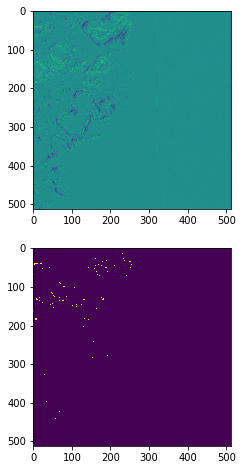

In [7]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

train_writer = tf.summary.FileWriter("./tf_logs", sess.graph)

accuracies, losses, train_acc = [], [], []
epochs = 1000
for i in xrange(epochs):
    ind1 = np.random.randint(len(train_inds))
    img = transform.resize(io.imread('cancer_data/inputs/train/' + train_inputs[ind1]), (512,512,3), 
                           mode='constant').reshape((1,512,512,3))
    lbl = transform.resize(io.imread('cancer_data/outputs/train/' + train_inputs[ind1]), (512,512,3), 
                           order=0, mode='constant')[:,:,1].reshape((1,512,512,1))
    _, _, acc = sess.run([train_step, cross_entropy, accuracy], feed_dict={x: img, y_true: lbl})
    train_acc.append(acc)
    if (i % 100 == 0 or i == epochs-1) and i>0:
        test_acc, test_loss = 0, 0
        for j in test_inds:
            img2 = transform.resize(io.imread('cancer_data/inputs/test/' + test_inputs[j]), 
                                    (512,512,3), mode='constant').reshape((1,512,512,3))
            lbl2 = transform.resize(io.imread('cancer_data/outputs/test/' + test_inputs[j]), 
                                    (512,512,3), order=0, mode='constant')[:,:,1].reshape((1,512,512,1))
            loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: img2, y_true: lbl2})
            test_acc += acc
            test_loss += loss
        accuracies.append(test_acc/len(test_inds))
        losses.append(test_loss/len(test_inds))
        print '{} TRAIN ACC: {}\t TEST ACC: {}\t LOSS: {}'.format(i, np.mean(train_acc), test_acc/len(test_inds), test_loss/len(test_inds))
        print '-'*100
        train_acc = []

img = transform.resize(io.imread('cancer_data/inputs/test/pos_test_000072.png'), 
                                 (512,512,3), mode='constant').reshape((1,512,512,3))
lbl = transform.resize(io.imread('cancer_data/outputs/test/pos_test_000072.png'), 
                                 (512,512,1), mode='constant').reshape((1,512,512,1))
_, _, out = sess.run([h0,h1,h2], feed_dict={x: img, y_true: lbl})
print(out.shape)
out = np.reshape(out, [512, 512])   
predictedpic = out.copy()
predictedpic[out>.5] = 1
predictedpic[out<=.5] = 0
image.imsave('test_l2_2.png', predictedpic)
plt.subplot(211)
plt.imshow(out)
plt.subplot(212)
img_plot = plt.imread('test_l2_2.png')
plt.imshow(img_plot)
plt.show()
train_writer.close()

## Dropout

In [ ]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [1,512,512,3])
y_hat = tf.placeholder(tf.float32, [1,512,512,1])
y_true = tf.placeholder(tf.float32, [1,512,512,1])

keep_prob = .8
h = conv(x, name="h", num_filters=64) # [1, 512, 512, 64]
tf.nn.dropout(h, keep_prob)
h0 = conv(x, name="h0", num_filters=32) # [1, 512, 512, 32]
tf.nn.dropout(h0, keep_prob)
h1 = conv(h0, name="h1", num_filters=16) # [1, 512, 512, 16]
tf.nn.dropout(h1, keep_prob)
h2 = conv(h1, name='h2', is_output=True, num_filters=1)
print h2.get_shape().as_list()

with tf.name_scope("loss_function") as scope:
    cross_entropy = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=tf.reshape(h2, (1,512*512)), 
                                                                          labels=tf.reshape(y_true, (1,512*512))))

with tf.name_scope("accuracy") as scope:
    y_hat = tf.cast(h2>.5, tf.float32)
    correct_prediction = tf.equal(y_true, y_hat)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

In [ ]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
train_writer = tf.summary.FileWriter("./tf_logs", sess.graph)

accuracies, losses, train_acc = [], [], []
epochs = 1000
for i in xrange(epochs):
    ind1 = np.random.randint(len(train_inds))
    img = transform.resize(io.imread('cancer_data/inputs/train/' + train_inputs[i]), (512,512,3), 
                           mode='constant').reshape((1,512,512,3))
    lbl = transform.resize(io.imread('cancer_data/outputs/train/' + train_inputs[i]), (512,512,3), 
                           order=0, mode='constant')[:,:,1].reshape((1,512,512,1))
    _, _, acc = sess.run([train_step, cross_entropy, accuracy], feed_dict={x: img, y_true: lbl})
    train_acc.append(acc)
    if i % 100 == 0 or i == epochs-1:
        test_acc, test_xent = 0, 0
        for j in test_inds:
            img2 = transform.resize(io.imread('cancer_data/inputs/test/' + test_inputs[j]), 
                                    (512,512,3), mode='constant').reshape((1,512,512,3))
            lbl2 = transform.resize(io.imread('cancer_data/outputs/test/' + test_inputs[j]), 
                                    (512,512,3), order=0, mode='constant')[:,:,1].reshape((1,512,512,1))
            xent, acc = sess.run([cross_entropy, accuracy], feed_dict={x: img2, y_true: lbl2})
            test_acc += acc
            test_xent += xent
        accuracies.append(test_acc/len(test_inds))
        losses.append(test_xent/len(test_inds))
        print '{} TRAIN ACC: {}\t TEST ACC: {}\t LOSS: {}'.format(i, np.mean(train_acc), test_acc/len(test_inds), test_xent/len(test_inds))
        print '-'*100
        train_acc = []

img = transform.resize(io.imread('cancer_data/inputs/test/pos_test_000072.png'), 
                                 (512,512,3), mode='constant').reshape((1,512,512,3))
lbl = transform.resize(io.imread('cancer_data/outputs/test/pos_test_000072.png'), 
                                 (512,512,1), mode='constant').reshape((1,512,512,1))
_, _, out = sess.run([h0,h1,h2], feed_dict={x: img, y_true: lbl})
print(out.shape)
out = np.reshape(out, [512, 512])   
predictedpic = out.copy()
predictedpic[out>.5] = 1
predictedpic[out<=.5] = 0
image.imsave('testdropout_2.png', predictedpic)
plt.subplot(211)
plt.imshow(out)
plt.subplot(212)
img_plot = plt.imread('testdropout_2.png')
plt.imshow(img_plot)
plt.show()
train_writer.close()

In [ ]:
predictedpic